## Laboratorio #5 Analisis de paquetes de Red


In [12]:
# Lo primero es importar las librerias que necesitamos 

from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import matplotlib.pyplot as plt
import binascii
import seaborn as sns
sns.set(color_codes=True)

In [13]:
# Ahora capturaremos 10 paquetes

num_of_packets_to_sniff = 10
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated 
print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]


<class 'scapy.plist.PacketList'>
10
<Sniffed: TCP:4 UDP:6 ICMP:0 Other:0>


<Ether  dst=01:00:5e:7f:ff:fa src=00:00:ca:01:02:03 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=311 id=0 flags=DF frag=0 ttl=1 proto=udp chksum=0x6410 src=192.168.100.3 dst=239.255.255.250 |<UDP  sport=34726 dport=ssdp len=291 chksum=0xa19f |<Raw  load='NOTIFY * HTTP/1.1\r\nHOST:239.255.255.250:1900\r\nCache-Control:max-age=60\r\nLocation:http://192.168.100.3:6666/WFADeviceDesc.xml\r\nServer: SDK 4.1.2.0 UPnP/1.0 MiniUPnPd/1.6_MTK_v2_001\r\nNT:upnp:rootdevice\r\nUSN:uuid:bc329e00-1dd8-11b2-8601-50a5dce806b4::upnp:rootdevice\r\nNTS:ssdp:alive\r\n\r\n' |>>>>

In [14]:
a = rdpcap('./analisis_paquetes.pcap')
print(a)

<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>


In [15]:
# Ahora uniremos ambos paquetes y procederemos a trabajar con uno solo. 

pac1= pcap 
pac2 = a 

all = pac1 + pac2

wrpcap('combinado.pcap', all)
combi = rdpcap('./combinado.pcap')
print(combi)

<combinado.pcap: TCP:4 UDP:68 ICMP:0 Other:0>


Como podemos ver, ahora ya tenemmos un archivo que cuenta con todos los daros que necesitamos para trabajar, para eso ahora haremos un DataFrame con el archivo. 

In [16]:
# crear un dataframe del archivo: ### --- METODO --- ###

# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(6))

  version ihl tos  len     id flags frag ttl proto chksum  ... dataofs  \
0       4   5   0  311      0    DF    0   1    17  25616  ...    None   
1       4   5   0  375      0    DF    0   1    17  25552  ...    None   
2       4   5   0  385      0    DF    0   1    17  25542  ...    None   
3       4   5   0   78  18394          0  64    17   5666  ...    None   
4       4   5   0  246  25887    DF    0  60    17  48180  ...    None   
5       4   5   0   52  59609    DF    0  64     6  53055  ...       8   

  reserved flags  window chksum urgptr options payload  \
0     None  None    None  41375   None    None     283   
1     None  None    None  54339   None    None     347   
2     None  None    None  65422   None    None     357   
3     None  None    None   2086   None    None      50   
4     None  None    None  10553   None    None     218   
5        0     S   64240  28299      0       6       0   

                                         payload_raw  \
0  b'NOTIFY * HTTP

Como podemos ya tenemos armado el dataset, con todos los datos que necesitabamos, ahora procederemos a ubicar ciertos valores especificos. 

In [17]:
df[['src','dst','sport','dport', 'payload']]

,src,dst,sport,dport,payload
0,192.168.100.3,239.255.255.250,34726,1900,283
1,192.168.100.3,239.255.255.250,34726,1900,347
2,192.168.100.3,239.255.255.250,34726,1900,357
3,192.168.0.13,10.240.80.254,50246,53,50
4,10.240.80.254,192.168.0.13,53,50246,218
5,192.168.0.13,52.182.141.63,62754,443,0
6,192.168.0.13,52.182.141.63,62755,443,0
7,52.182.141.63,192.168.0.13,443,62755,0
8,192.168.0.13,52.182.141.63,62755,443,0


In [18]:
#Calcular estadistica del SRC ADDRESS
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

# Top Source Address
count                9
unique               4
top       192.168.0.13
freq                 4
Name: src, dtype: object 




In [19]:
#Calcular estadistica del Dst ADDRESS
print("# Top Source Address")
print(df['dst'].describe(),'\n\n')

# Top Source Address
count                   9
unique                  4
top       239.255.255.250
freq                    3
Name: dst, dtype: object 




In [20]:
#Calcular estadistica del SRC Port
print("# Top Source Address")
print(df['sport'].describe(),'\n\n')

# Top Source Address
count         9
unique        6
top       34726
freq          3
Name: sport, dtype: int64 




In [21]:
#Calcular estadistica del Dst Port
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

# Top Source Address
count                9
unique               4
top       192.168.0.13
freq                 4
Name: src, dtype: object 




#### Estadisticas

In [22]:
#¿Quien es la IP de origen mas frecuente?
frequent_address = df['src'].describe()['top']
print(frequent_address)

192.168.0.13


In [23]:
# A que IPs destino mas frecuente
print(df[df['src'] == frequent_address]['dst'].unique(),"\n\n")

['10.240.80.254' '52.182.141.63'] 




In [24]:
# Cual es la IP que se comunica mas la primera IP
print(df[df['dst'] == frequent_address]['src'].unique(),"\n\n")

['10.240.80.254' '52.182.141.63'] 




In [25]:
fd_df = df[df["src"] == frequent_address]
print("IPs a las que mas se comunica: ", fd_df["dst"].unique())
print("Puertos destinos a las que se comunica: ", fd_df["sport"].unique())

IPs a las que mas se comunica:  ['10.240.80.254' '52.182.141.63']
Puertos destinos a las que se comunica:  [50246 62754 62755]


#### Indique el propósito de los puertos que más aparece en los incisos d y e
Esto es por el DNS, es la funcionalidad del DNS lo que hace que estos puertos aparezcan.

### GRAFICAS
######  Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads enviados de dichas direcciones.

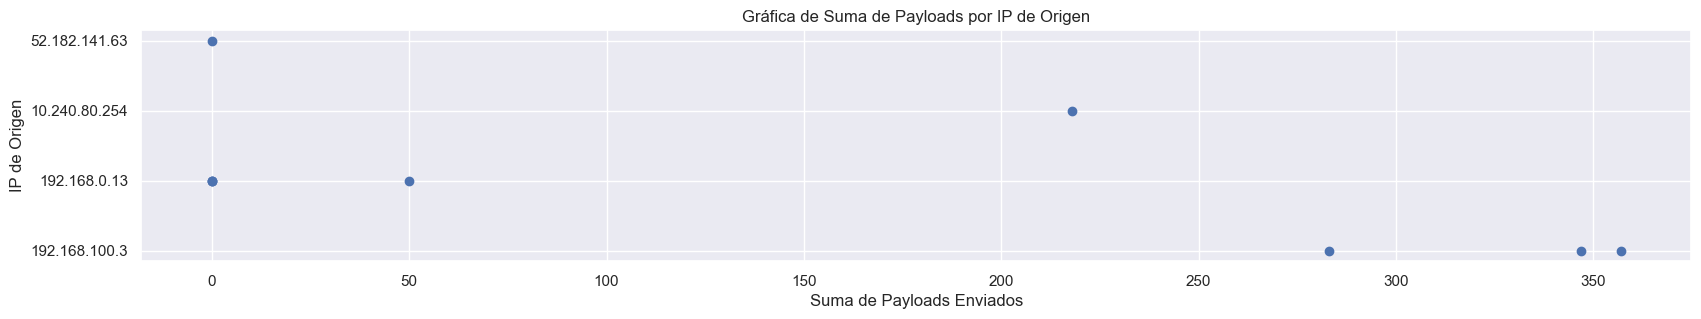

In [37]:
ips = df['src']
pay = df['payload']

plt.scatter(pay, ips)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('IP de Origen')
plt.title('Gráfica de Suma de Payloads por IP de Origen')
plt.show()

###### Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

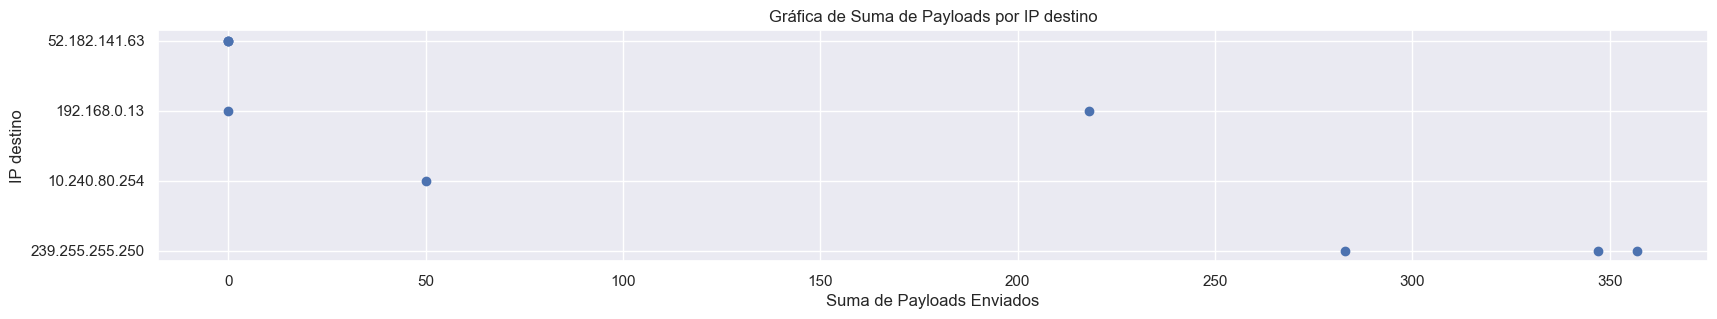

In [38]:
ips = df['dst']
pay = df['payload']

plt.scatter(pay, ips)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('IP destino')
plt.title('Gráfica de Suma de Payloads por IP destino')
plt.show()

######  Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los payloads enviados de dichos puertos.

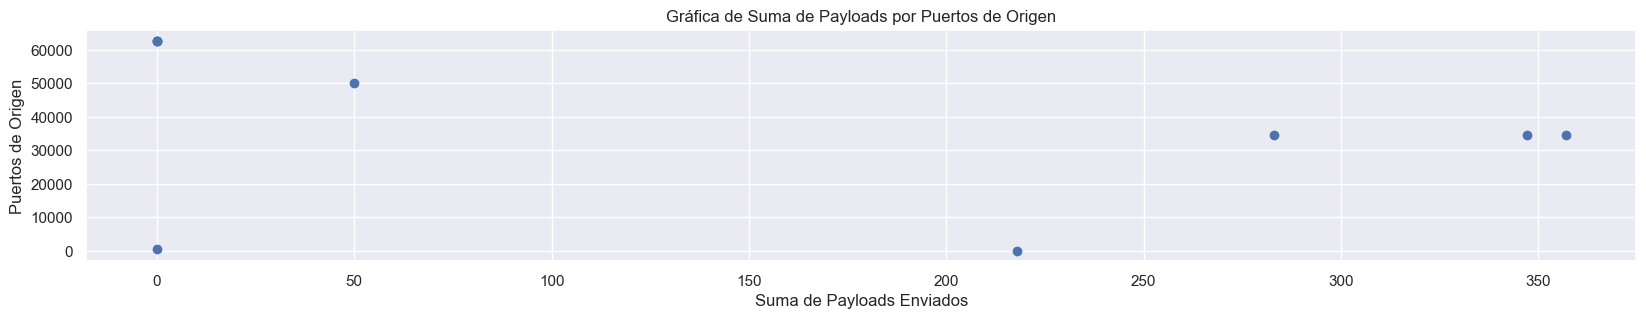

In [42]:
prto = df['sport']
pay = df['payload']

plt.scatter(pay, prto)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('Puertos de Origen')
plt.title('Gráfica de Suma de Payloads por Puertos de Origen')
plt.show()

######  Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos.

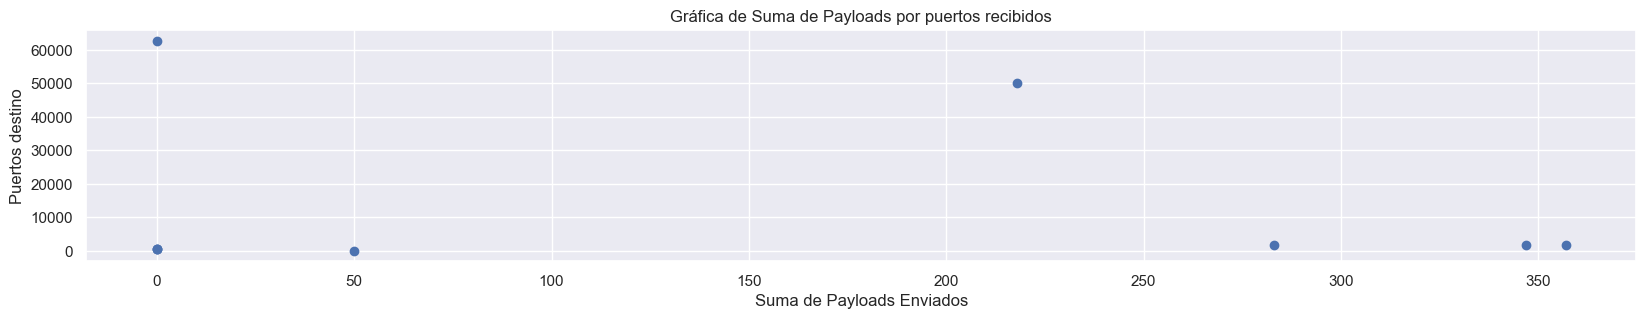

In [43]:
ips = df['dport']
pay = df['payload']

plt.scatter(pay, ips)
plt.xlabel('Suma de Payloads Enviados')
plt.ylabel('Puertos destino')
plt.title('Gráfica de Suma de Payloads por puertos recibidos')
plt.show()